# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.2726660928725586
 0.7528957198715633
 0.34845858464923263
 0.5451494589243062
 0.02271522905344381
 0.8658879036838949
 0.439932509751236
 0.7922017719424048
 0.1686863677770719
 0.9133193162567644
 0.19578846205778355
 0.6575179969346767
 0.09135278370989286
 ⋮
 0.9507063569684889
 0.5488468317048653
 0.5346645235027028
 0.7802165456982953
 0.7036382686272707
 0.7601457200830999
 0.9610500968214101
 0.30593356402053473
 0.2534151904462312
 0.7827011757393881
 0.24647760258206164
 0.12984070192378416

In [2]:
sum(a)

5.000341936937251e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.009571 seconds (1 allocation: 16 bytes)


5.000341936937251e6

In [4]:
@time sum(a)

  0.009703 seconds (1 allocation: 16 bytes)


5.000341936937251e6

In [5]:
@time sum(a)

  0.010366 seconds (1 allocation: 16 bytes)


5.000341936937251e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed BenchmarkTools ─ v1.3.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.1
  [37e2e46d] + LinearAlgebra
  [9abbd945] + Profile
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
  [e66e0078] + CompilerSupportLibraries_jll
  [4536629a] + OpenBLAS_jll
  [8e850b90] + libblastrampoline_jll
Precompiling project...
  ✓ CompilerSupportLibraries_jll
  ✓ OpenBLAS_jll
  ✓ BenchmarkTools
  ✓ libblastrampoline_jll
  4 dependencies successfully precompiled in 2 seconds (15 already precompiled)


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.000341936937417e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

1.6577541828155518e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 312 samples with 1 evaluation.
 Range (min … max):  15.605 ms …  18.641 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.884 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.006 ms ± 426.252 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▆██▆▄▆▂▂▃                                                  
  ▄▇██████████▅▆▆▆▄▄▆▃▄▁▁▂▄▁▂▂▃▂▃▁▃▁▁▄▁▁▁▁▂▂▂▁▁▂▂▁▁▂▁▃▂▁▁▁▂▁▂▃ ▄
  15.6 ms         Histogram: frequency by time         17.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 15.604587 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 15.6046

In [18]:
using Plots

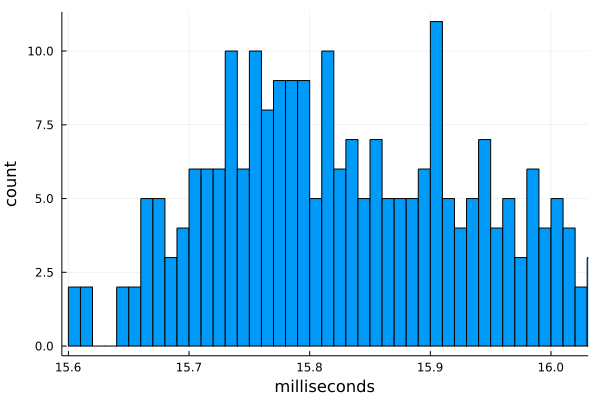

In [20]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [21]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [22]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 391 samples with 1 evaluation.
 Range (min … max):  11.672 ms … 26.231 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.558 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.753 ms ±  1.209 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▂▃▅▇██▇▅▆▅▃▃▂▁                                     
  ▄▄▄▄▁▄▄▄▆████████████████▇▄▄▄▆▁▁▇▄▆▆▄▁▄▁▄▄▆▄▆▁▄▁▁▁▁▆▁▁▁▁▄▁▄ ▇
  11.7 ms      Histogram: log(frequency) by time      14.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

11.672242

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [25]:
# using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
   Installed PyCall ─ v1.93.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [438e738f] + PyCall v1.93.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [438e738f] + PyCall v1.93.1
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1fc929f47d7c151c839c5fc1375929766fb8edcc/build.log`
Precompiling project...
  ✓ PyCall
  1 dependency successfully precompiled in 5 seconds (149 already precompiled)


In [26]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [27]:
pysum(a)

5.000341936937417e6

In [28]:
pysum(a) ≈ sum(a)

true

In [29]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  691.789 ms … 729.709 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     723.862 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   716.601 ms ±  13.758 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                     █           █                ██   █   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁█ ▁
  692 ms           Histogram: frequency by time          730 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [30]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 15.6046
  "Python built-in" => 691.789
  "C -ffast-math"   => 11.6722

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [32]:
# using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [8f4d0f93] + Conda v1.7.0
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [ ]:
# Conda.add("numpy")

In [33]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 432 samples with 1 evaluation.
 Range (min … max):   9.921 ms … 27.548 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     11.393 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   11.568 ms ±  1.567 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃█▃ ▁ ▁ ▂▄▇▃                                               
  ▄▆███▇███▆████▆▅▅▄▅▅▄▃▂▃▅▄▅▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂ ▃
  9.92 ms         Histogram: frequency by time        18.2 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [34]:
numpy_sum(a)

5.000341936937249e6

In [35]:
numpy_sum(a) ≈ sum(a)

true

In [36]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 15.6046
  "Python numpy"    => 9.92083
  "Python built-in" => 691.789
  "C -ffast-math"   => 11.6722

# 5. Python, hand-written 

In [37]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff94958a280>

In [38]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  824.136 ms … 888.357 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     838.494 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   849.904 ms ±  25.723 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █   ██                                 █           █  
  █▁▁▁▁▁▁▁▁█▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  824 ms           Histogram: frequency by time          888 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [39]:
sum_py(a)

5.000341936937417e6

In [40]:
sum_py(a) ≈ sum(a)

true

In [41]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 15.6046
  "Python numpy"        => 9.92083
  "Python hand-written" => 824.136
  "Python built-in"     => 691.789
  "C -ffast-math"       => 11.6722

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [42]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [43]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 518 samples with 1 evaluation.
 Range (min … max):  8.230 ms …  13.358 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.875 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.622 ms ± 783.026 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▃                        ▇██▅▁▂                           
  ▆███▇▄▄▃▃▄▃▃▃▄▃▃▃▂▃▃▃▃▃▄▄▅▇███████▆▄▅▄▃▄▃▃▃▃▂▂▂▂▃▁▃▁▂▁▁▂▂▁▃ ▄
  8.23 ms         Histogram: frequency by time        11.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 15.6046
  "Python numpy"        => 9.92083
  "Python hand-written" => 824.136
  "Python built-in"     => 691.789
  "Julia built-in"      => 8.23047
  "C -ffast-math"       => 11.6722

# 7. Julia (hand-written) 

In [45]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [46]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 304 samples with 1 evaluation.
 Range (min … max):  15.782 ms …  18.651 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.336 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.419 ms ± 416.705 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▃▇▇█▇▃▅▄▂▅▆▃                                          
  ▃▃▄▃▇▄▅▇████████████▇▆▄▃▁▄▃▁▁▃▃▃▄▁▃▃▃▁▁▃▃▃▃▃▁▁▁▁▃▃▁▃▃▃▁▃▁▁▁▃ ▄
  15.8 ms         Histogram: frequency by time         18.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [47]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 15.6046
  "Python numpy"        => 9.92083
  "Julia hand-written"  => 15.782
  "Python hand-written" => 824.136
  "Python built-in"     => 691.789
  "Julia built-in"      => 8.23047
  "C -ffast-math"       => 11.6722

# 8. Julia (hand-written w. simd) 

In [48]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [49]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 596 samples with 1 evaluation.
 Range (min … max):  7.968 ms …  10.512 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.265 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.378 ms ± 364.599 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▇██▆▇█▁▂                                                 
  ▃▃▄█████████▇▇▆▆▄▆▅▄▄▃▃▃▃▃▃▂▃▃▁▃▂▂▁▃▃▂▂▃▃▁▂▂▃▁▁▂▂▂▁▂▁▂▁▃▁▃▂ ▃
  7.97 ms         Histogram: frequency by time        9.89 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [50]:
mysum_simd(a)

5.000341936937251e6

In [51]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 7.96801
  "C"                       => 15.6046
  "Python numpy"            => 9.92083
  "Julia hand-written"      => 15.782
  "Python hand-written"     => 824.136
  "Python built-in"         => 691.789
  "Julia built-in"          => 8.23047
  "C -ffast-math"           => 11.6722

# Summary

In [52]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....8.0
Julia built-in..............8.2
Python numpy................9.9
C -ffast-math..............11.7
C..........................15.6
Julia hand-written.........15.8
Python built-in...........691.8
Python hand-written.......824.1
